In [48]:
import numpy as np
import matplotlib.pyplot as plt

In [49]:
def generate_linear_data():
    np.random.seed(0)
    N = 500

    c1 = np.random.randn(N, 2) + [2, 2]
    c2 = np.random.randn(N, 2) + [-2, -2]
    c3 = np.random.randn(N, 2) + [2, -2]

    X = np.vstack([c1, c2, c3])
    y = np.array([0]*N + [1]*N + [2]*N)
    return X, y

In [50]:
def generate_nonlinear_data():
    np.random.seed(42)
    N = 500

    theta = np.linspace(0, 2*np.pi, N)

    r1 = 1.0
    r2 = 2.0

    c1 = np.c_[r1*np.cos(theta), r1*np.sin(theta)]
    c2 = np.c_[r2*np.cos(theta), r2*np.sin(theta)]
    c3 = np.random.randn(N, 2) * 0.5

    X = np.vstack([c1, c2, c3])
    y = np.array([0]*N + [1]*N + [2]*N)

    return X, y


In [51]:
def split_data(X, y):
    X_tr, X_val, X_te = [], [], []
    y_tr, y_val, y_te = [], [], []

    for cls in np.unique(y):
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)

        n = len(idx)
        t1, t2 = int(0.6*n), int(0.8*n)

        X_tr.append(X[idx[:t1]])
        y_tr.append(y[idx[:t1]])

        X_val.append(X[idx[t1:t2]])
        y_val.append(y[idx[t1:t2]])

        X_te.append(X[idx[t2:]])
        y_te.append(y[idx[t2:]])

    return (np.vstack(X_tr), np.hstack(y_tr),
            np.vstack(X_val), np.hstack(y_val),
            np.vstack(X_te), np.hstack(y_te))


In [52]:
def one_hot(y, C):
    Y = np.zeros((len(y), C))
    for i, label in enumerate(y):
        Y[i, label] = 1
    return Y


In [53]:

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)


In [54]:
class FCNN:
    def __init__(self, input_size, hidden_size, output_size, lr=0.01):
        self.lr = lr

        self.W1 = np.random.randn(input_size, hidden_size) * 0.1
        self.b1 = np.zeros(hidden_size)

        self.W2 = np.random.randn(hidden_size, output_size) * 0.1
        self.b2 = np.zeros(output_size)

    # ✅ FORWARD PASS
    def forward(self, x):
        self.z1 = x @ self.W1 + self.b1
        self.a1 = 1 / (1 + np.exp(-self.z1))

        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = 1 / (1 + np.exp(-self.z2))
        return self.a2

    # Squared error backprop (SGD)
    def backward(self, x, y):
        d2 = (self.a2 - y) * self.a2 * (1 - self.a2)
        dW2 = np.outer(self.a1, d2)
        db2 = d2

        d1 = (self.W2 @ d2) * self.a1 * (1 - self.a1)
        dW1 = np.outer(x, d1)
        db1 = d1

        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1


In [55]:
def train(model, X, Y, epochs=100):
    losses = []

    for epoch in range(epochs):
        err = 0
        for x, y in zip(X, Y):
            out = model.forward(x)
            err += np.sum((out - y)**2)
            model.backward(x, y)

        losses.append(err / len(X))

    return losses


In [56]:
X, y = generate_linear_data()
X_tr, y_tr, X_val, y_val, X_te, y_te = split_data(X, y)

Y_tr = one_hot(y_tr, 3)

model1 = FCNN(2, 5, 3, lr=0.05)
loss1 = train(model1, X_tr, Y_tr, epochs=200)


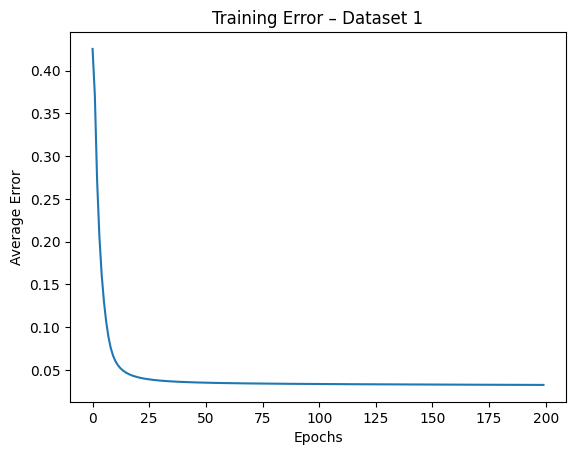

In [57]:
plt.plot(loss1)
plt.xlabel("Epochs")
plt.ylabel("Average Error")
plt.title("Training Error – Dataset 1")
plt.show()


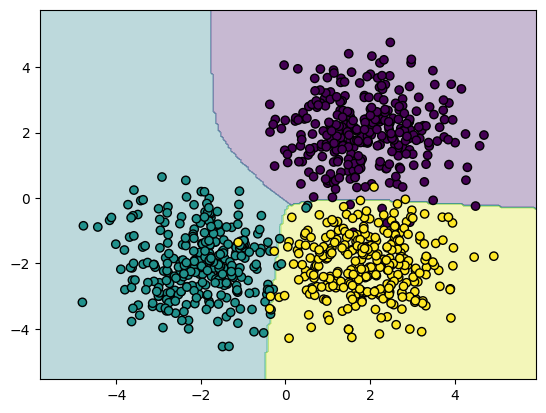

In [58]:
def plot_decision(model, X, y):
    xx, yy = np.meshgrid(
        np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200),
        np.linspace(X[:,1].min()-1, X[:,1].max()+1, 200)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.array([np.argmax(model.forward(p)) for p in grid])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:,0], X[:,1], c=y, edgecolors='k')
    plt.show()

plot_decision(model1, X_tr, y_tr)



In [59]:
def evaluate(model, X, y):
    preds = np.array([np.argmax(model.forward(x)) for x in X])
    acc = np.mean(preds == y)

    C = len(np.unique(y))
    cm = np.zeros((C, C), int)
    for t, p in zip(y, preds):
        cm[t, p] += 1

    return acc, cm
acc, cm = evaluate(model1, X_val, y_val)
acc2,cm2 = evaluate(model1, X_te, y_te)
print("Validation Accuracy:", acc)
print("Confusion Matrix:\n", cm)
print("Test Accuracy:", acc2)
print("Test Confusion Matrix:\n", cm2)


Validation Accuracy: 0.9466666666666667
Confusion Matrix:
 [[98  0  2]
 [ 0 94  6]
 [ 5  3 92]]
Test Accuracy: 0.97
Test Confusion Matrix:
 [[98  0  2]
 [ 0 97  3]
 [ 2  2 96]]


In [60]:
X, y = generate_nonlinear_data()
X_tr, y_tr, X_val, y_val, X_te, y_te = split_data(X, y)

Y_tr = one_hot(y_tr, 3)


In [61]:
class FCNN_2Hidden:
    def __init__(self, input_size, h1, h2, output_size, lr=0.05):
        self.lr = lr

        self.W1 = np.random.randn(input_size, h1) * 0.1
        self.b1 = np.zeros(h1)

        self.W2 = np.random.randn(h1, h2) * 0.1
        self.b2 = np.zeros(h2)

        self.W3 = np.random.randn(h2, output_size) * 0.1
        self.b3 = np.zeros(output_size)

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def forward(self, x):
        self.z1 = x @ self.W1 + self.b1
        self.a1 = self.sigmoid(self.z1)

        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.sigmoid(self.z2)

        self.z3 = self.a2 @ self.W3 + self.b3
        self.a3 = self.sigmoid(self.z3)

        return self.a3

    def backward(self, x, y):
        d3 = (self.a3 - y) * self.a3 * (1 - self.a3)
        dW3 = np.outer(self.a2, d3)
        db3 = d3

        d2 = (self.W3 @ d3) * self.a2 * (1 - self.a2)
        dW2 = np.outer(self.a1, d2)
        db2 = d2

        d1 = (self.W2 @ d2) * self.a1 * (1 - self.a1)
        dW1 = np.outer(x, d1)
        db1 = d1

        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1


In [62]:
model2 = FCNN_2Hidden(2, 8, 5, 3, lr=0.05)
loss2 = train(model2, X_tr, Y_tr, epochs=300)


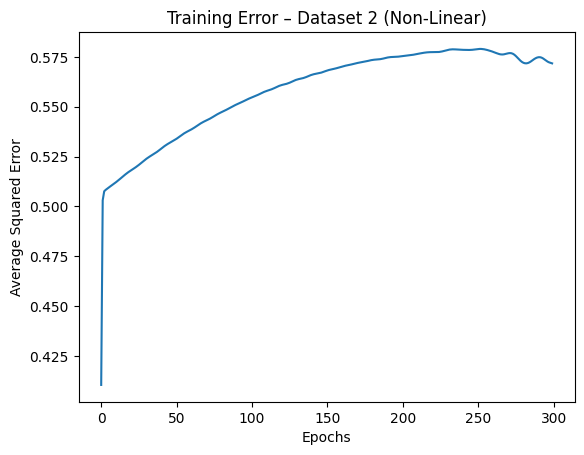

In [63]:
plt.plot(loss2)
plt.xlabel("Epochs")
plt.ylabel("Average Squared Error")
plt.title("Training Error – Dataset 2 (Non-Linear)")
plt.show()


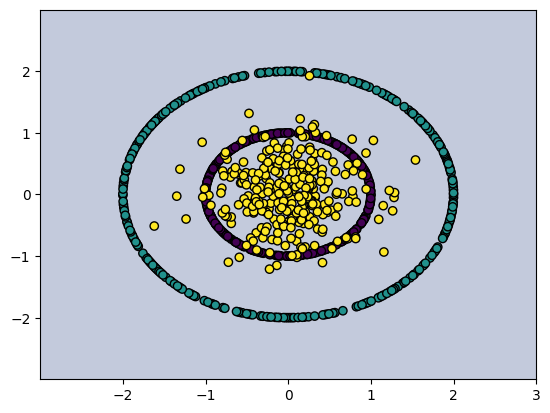

In [64]:
plot_decision(model2, X_tr, y_tr)


In [65]:
acc_val, cm_val = evaluate(model2, X_val, y_val)

print("Validation Accuracy:", acc_val)
print("Confusion Matrix:\n", cm_val)


Validation Accuracy: 0.3333333333333333
Confusion Matrix:
 [[  0   0 100]
 [  0   0 100]
 [  0   0 100]]


In [66]:
acc_test, cm_test = evaluate(model2, X_te, y_te)

print("Test Accuracy:", acc_test)
print("Test Confusion Matrix:\n", cm_test)


Test Accuracy: 0.3333333333333333
Test Confusion Matrix:
 [[  0   0 100]
 [  0   0 100]
 [  0   0 100]]


In [67]:
from mpl_toolkits.mplot3d import Axes3D

def plot_node_outputs(model, X, title_prefix=""):
    X1 = X[:, 0]
    X2 = X[:, 1]

    outputs = []

    # Forward pass manually to collect node outputs
    z1 = X @ model.W1 + model.b1
    a1 = 1 / (1 + np.exp(-z1))
    outputs.append(a1)

    if hasattr(model, "W2") and hasattr(model, "W3"):
        z2 = a1 @ model.W2 + model.b2
        a2 = 1 / (1 + np.exp(-z2))
        outputs.append(a2)

        z3 = a2 @ model.W3 + model.b3
        a3 = 1 / (1 + np.exp(-z3))
        outputs.append(a3)
    else:
        z2 = a1 @ model.W2 + model.b2
        a2 = 1 / (1 + np.exp(-z2))
        outputs.append(a2)

    for layer_idx, layer in enumerate(outputs):
        for neuron_idx in range(layer.shape[1]):
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.scatter(X1, X2, layer[:, neuron_idx], c=layer[:, neuron_idx], cmap='viridis')
            ax.set_xlabel("x₁")
            ax.set_ylabel("x₂")
            ax.set_zlabel("Neuron Output")
            ax.set_title(f"{title_prefix} Layer {layer_idx+1} – Neuron {neuron_idx+1}")
            plt.show()


Training Data


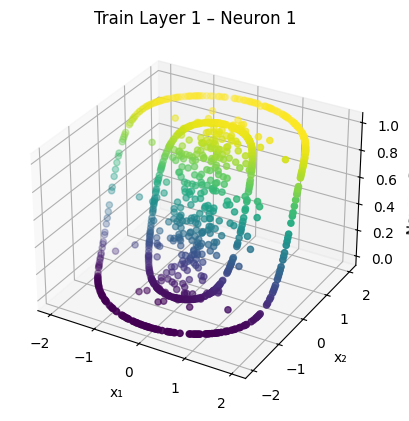

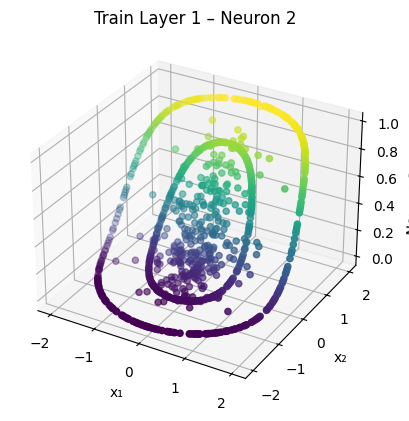

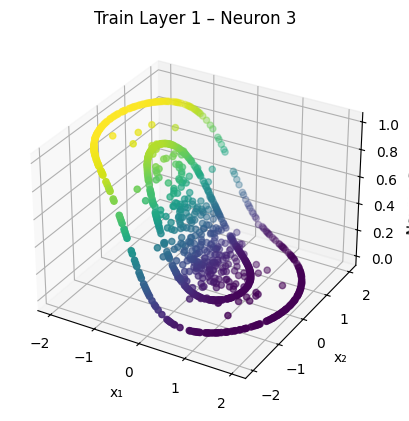

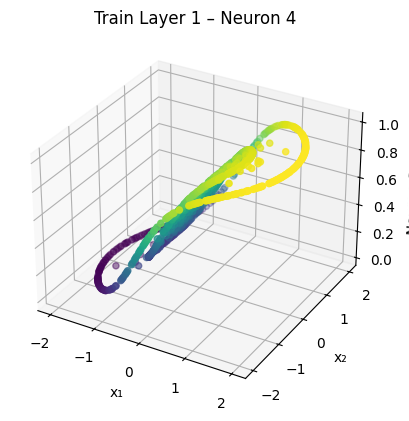

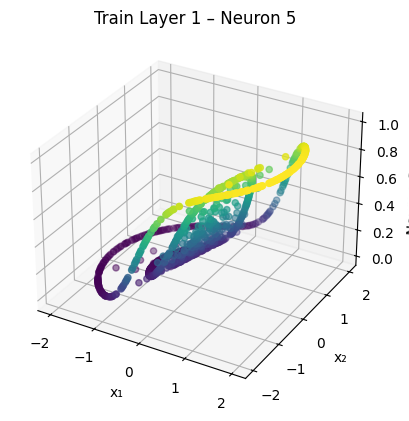

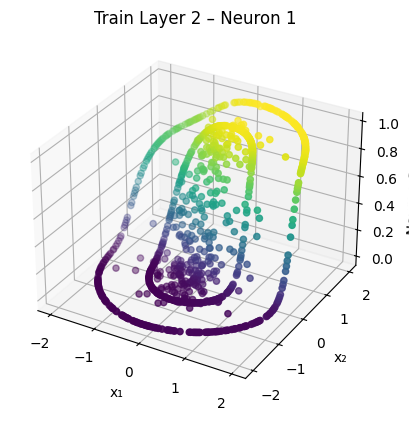

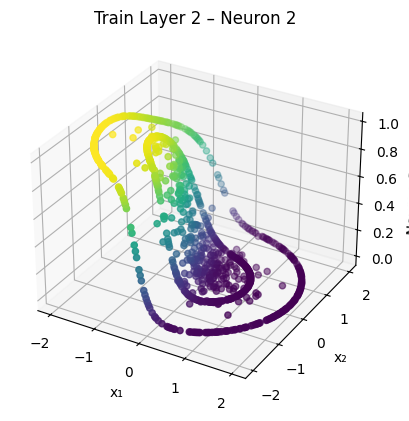

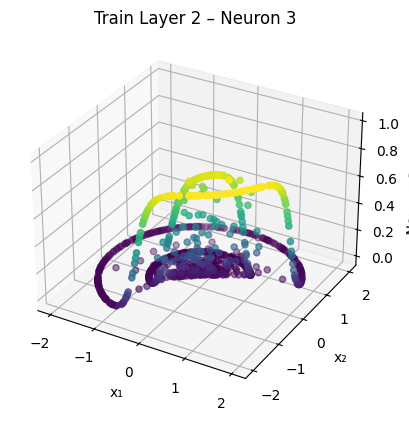

Validation Data


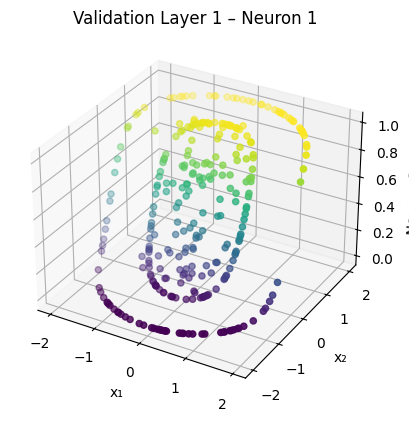

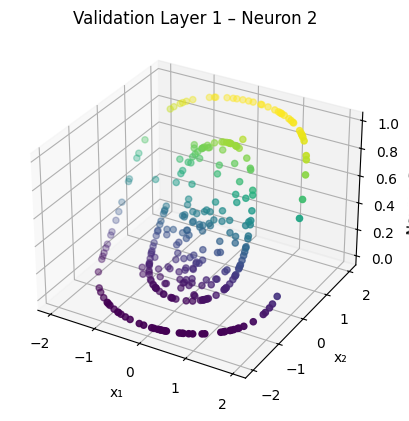

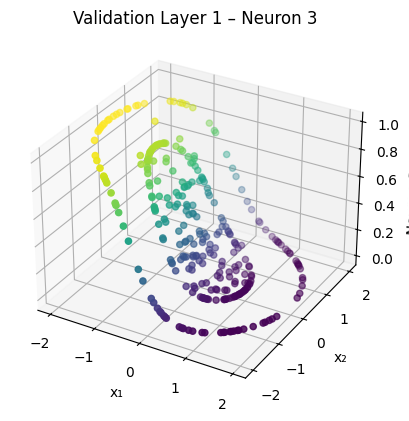

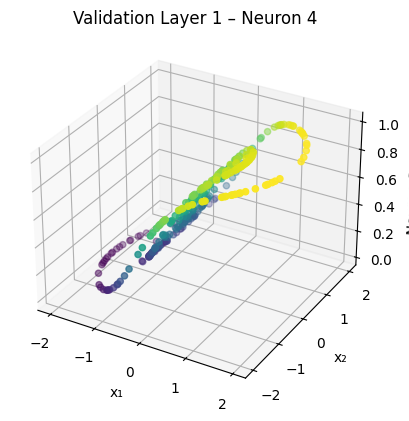

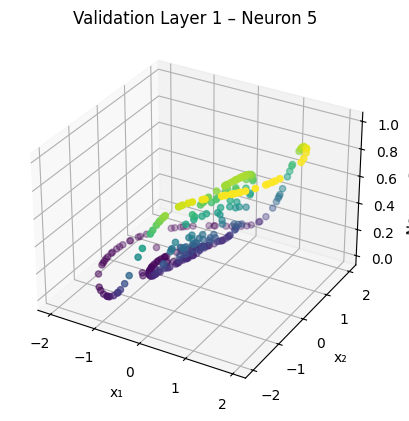

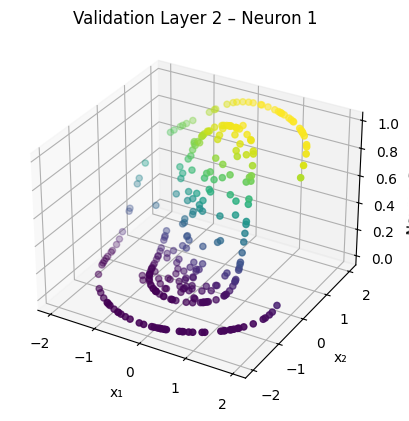

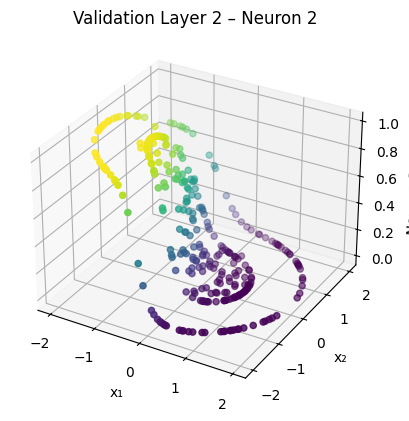

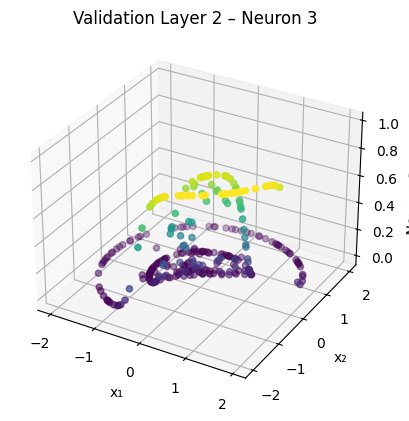

Test Data


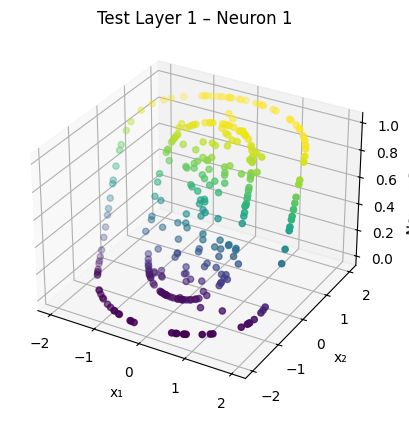

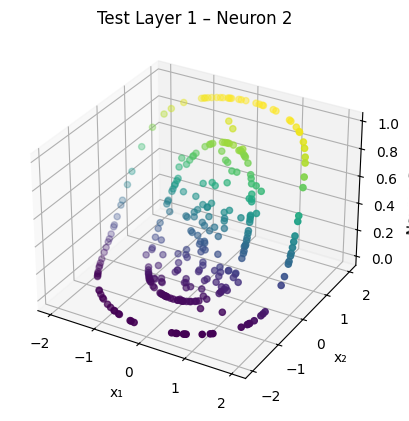

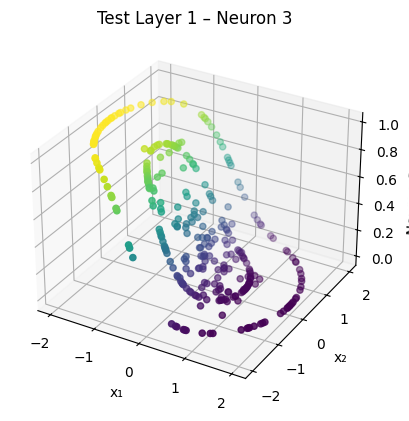

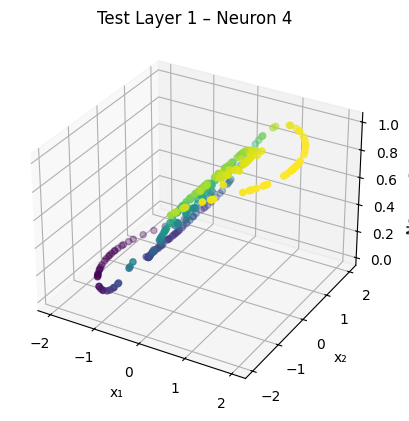

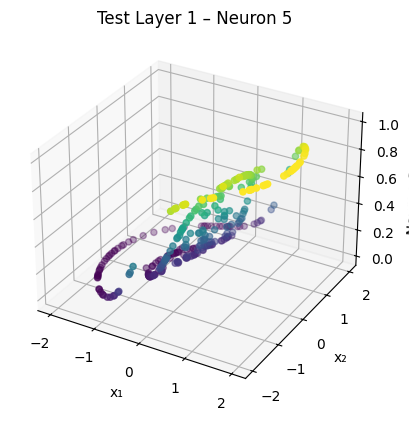

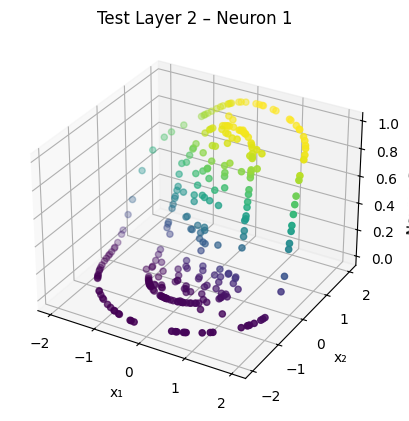

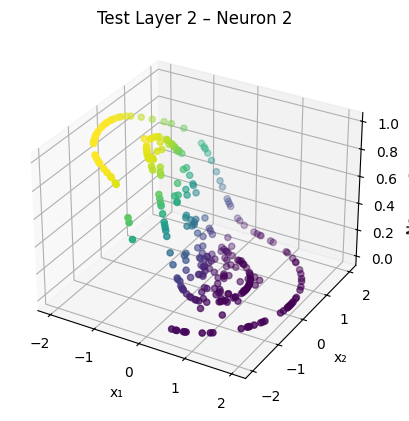

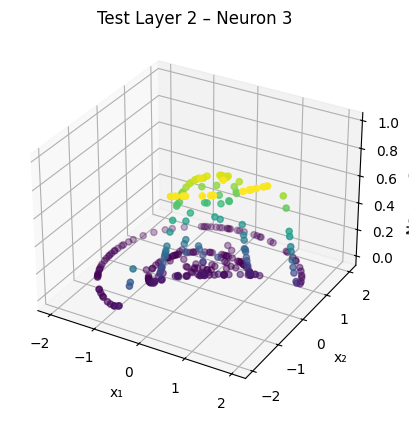

In [68]:
print("Training Data")
plot_node_outputs(model1, X_tr, "Train")

print("Validation Data")
plot_node_outputs(model1, X_val, "Validation")

print("Test Data")
plot_node_outputs(model1, X_te, "Test")


Training Data


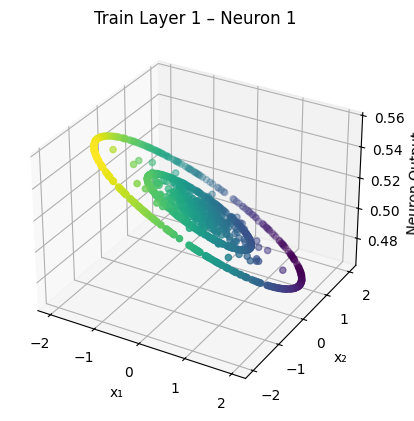

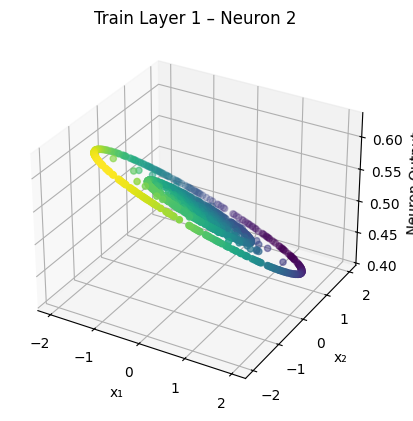

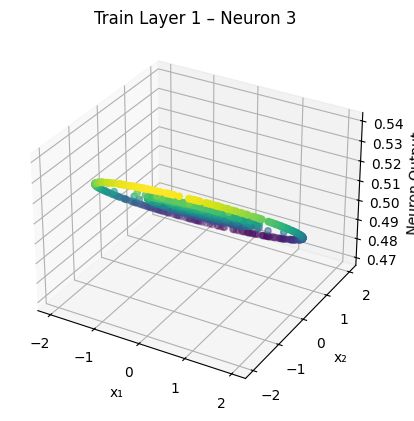

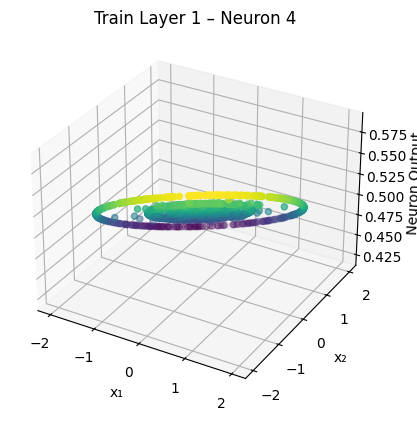

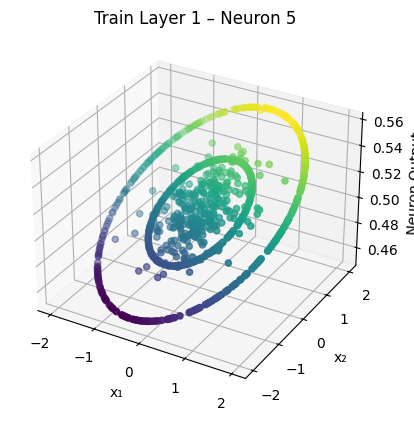

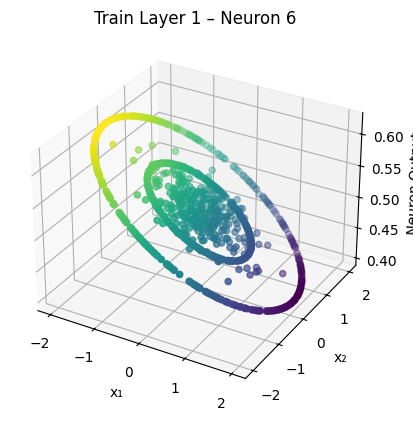

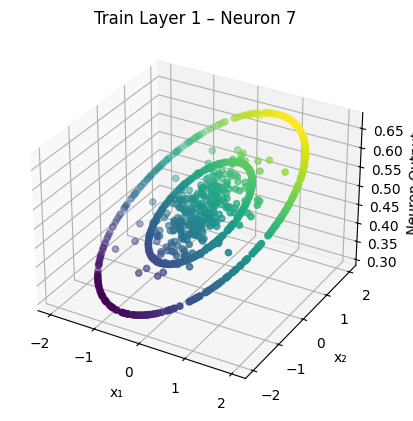

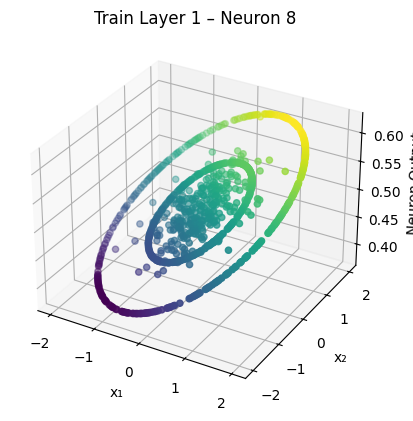

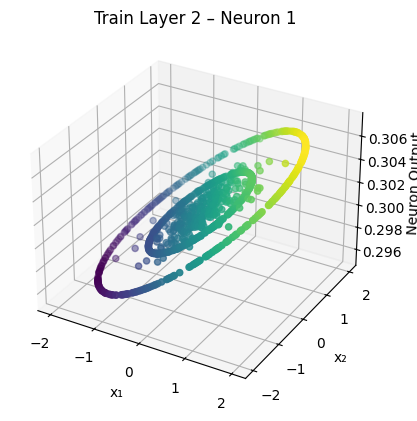

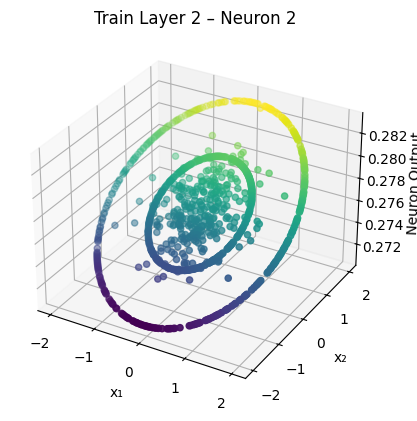

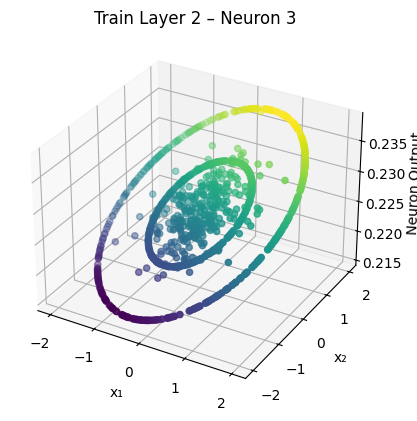

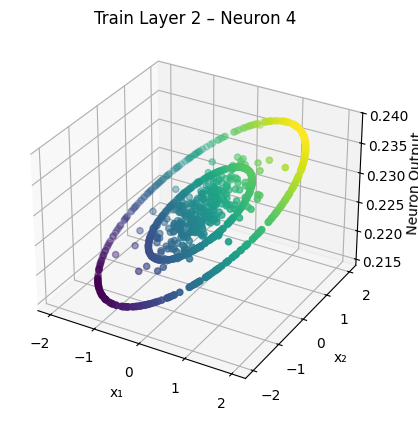

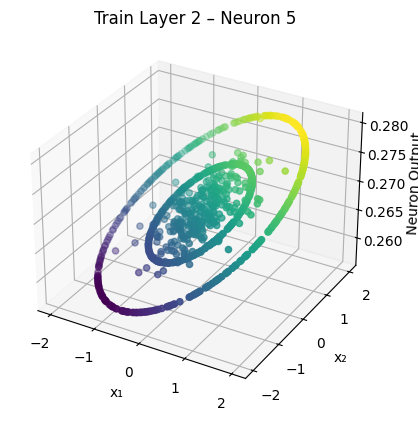

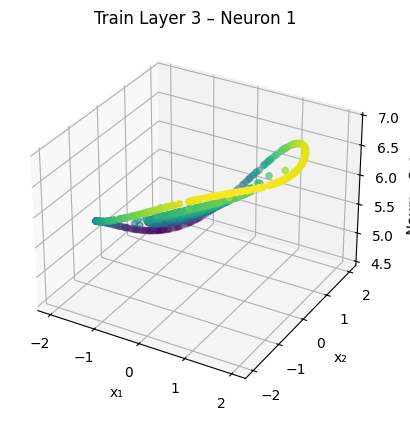

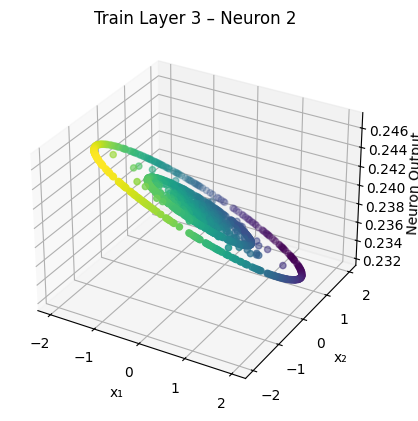

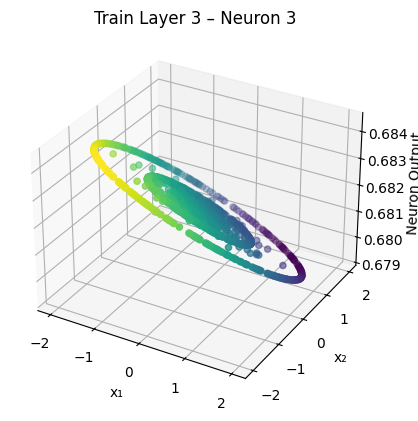

Validation Data


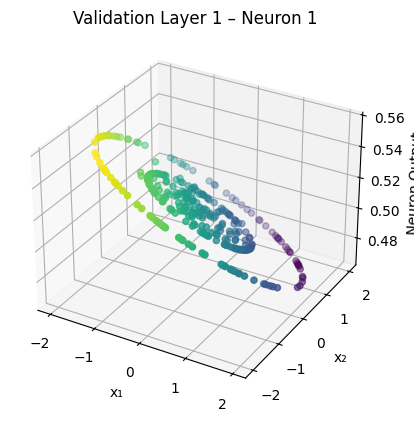

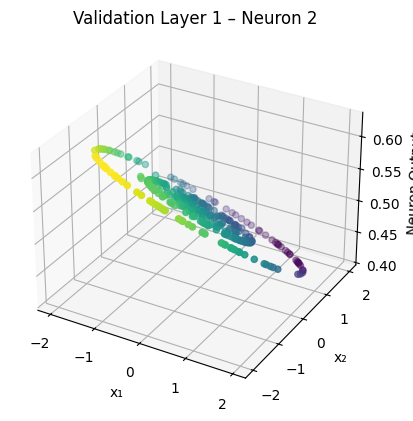

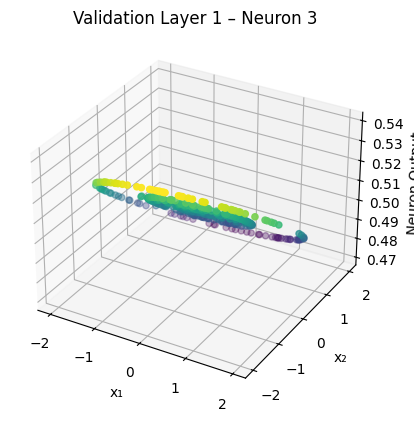

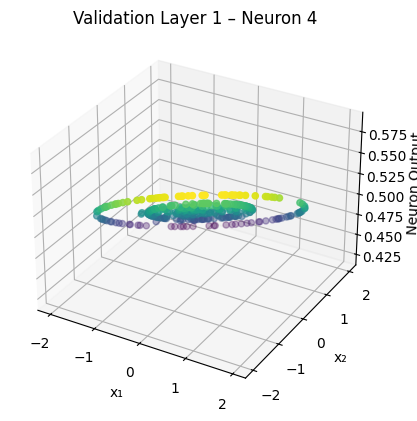

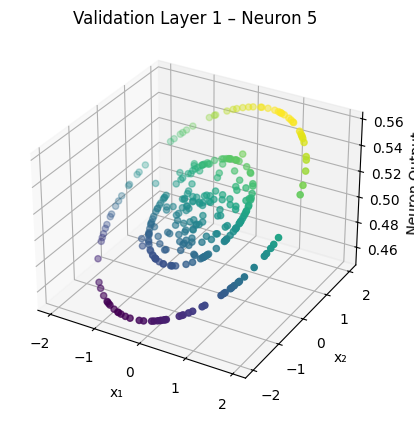

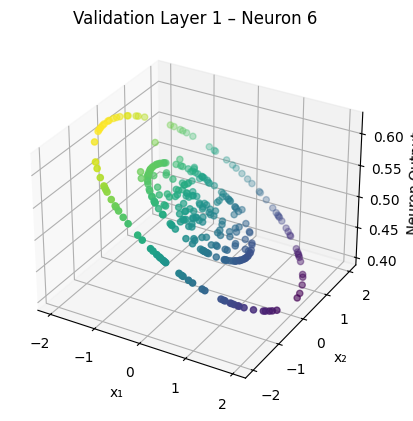

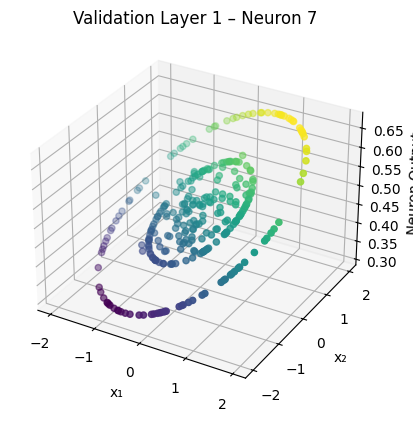

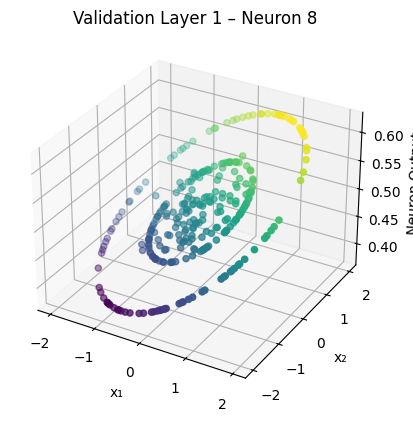

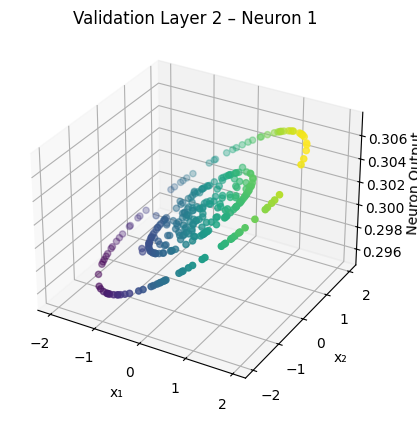

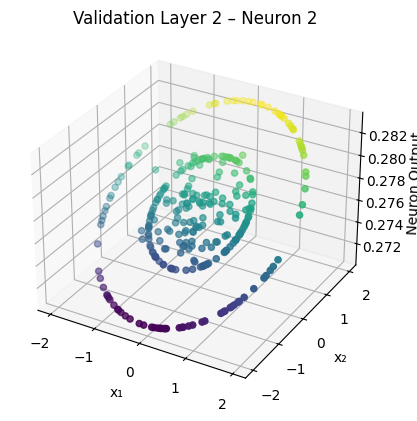

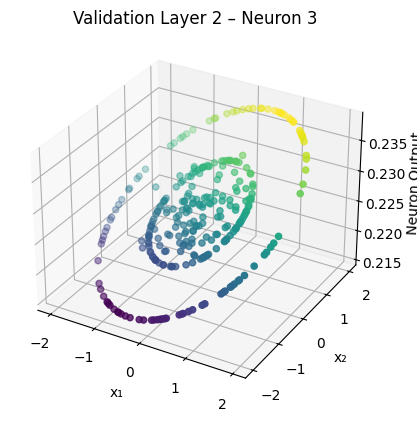

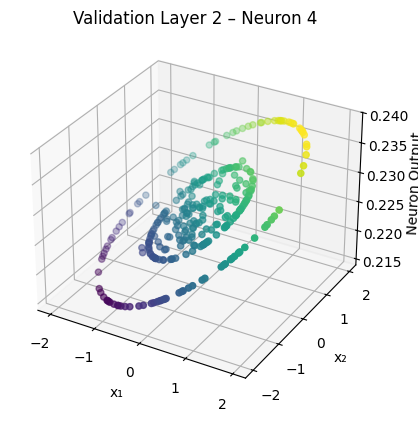

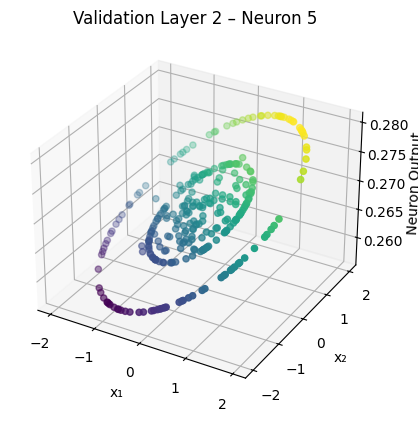

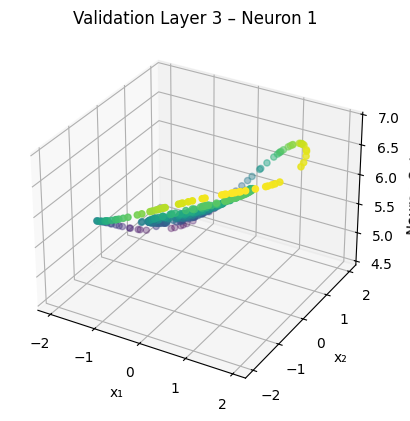

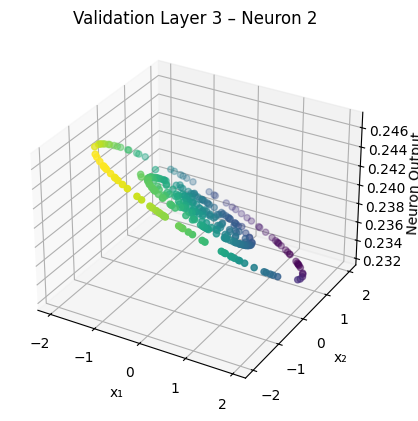

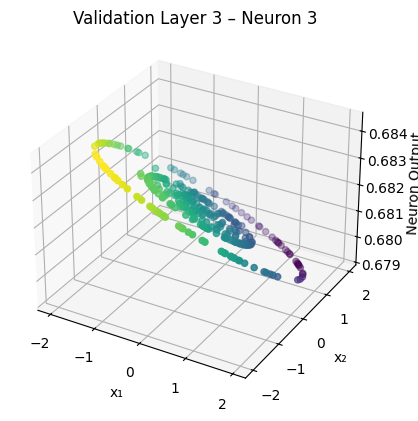

Test Data


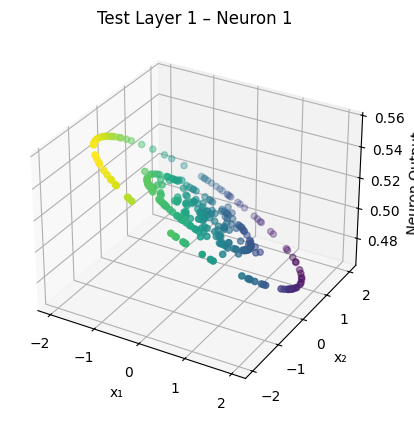

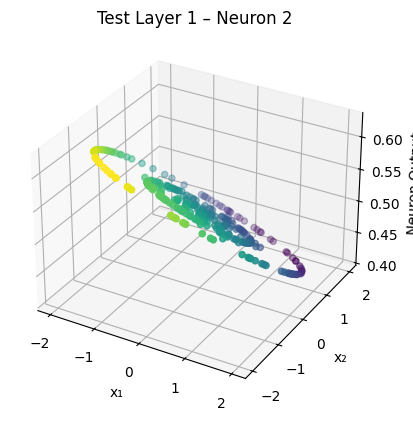

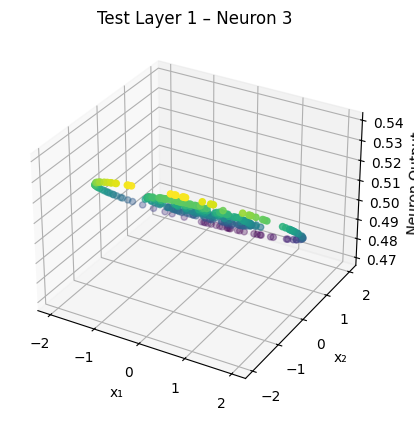

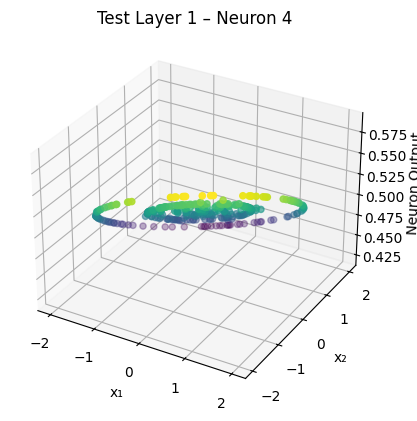

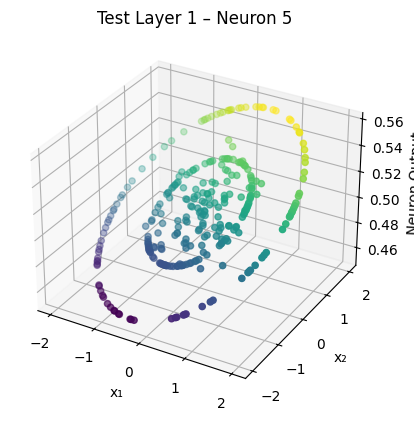

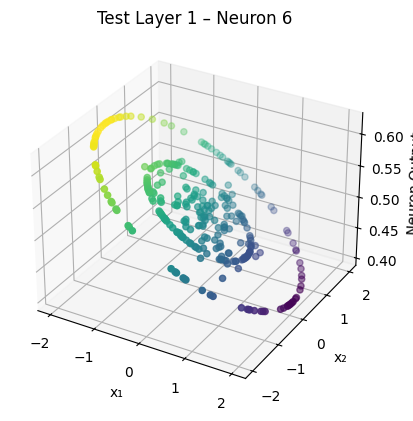

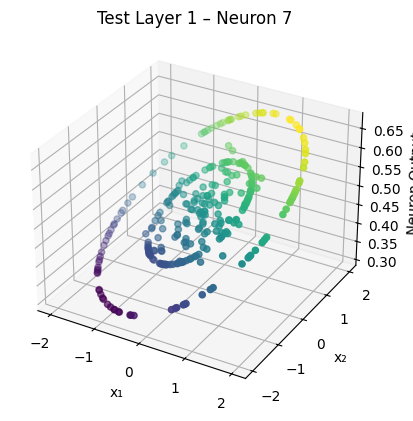

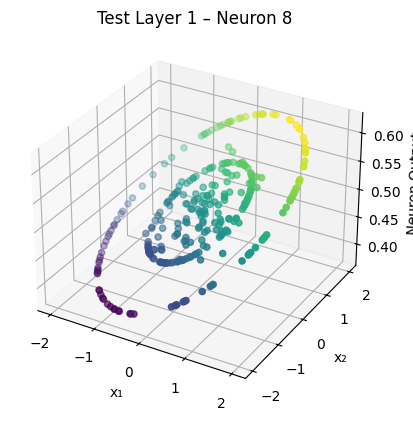

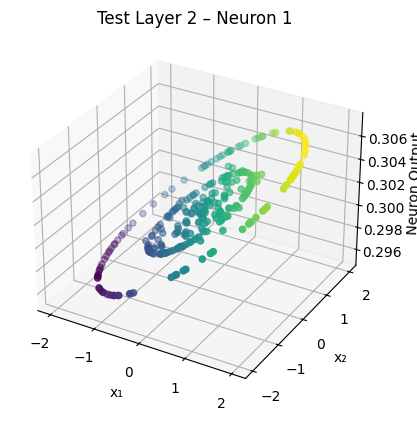

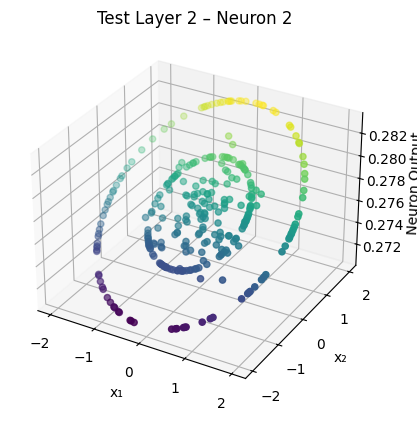

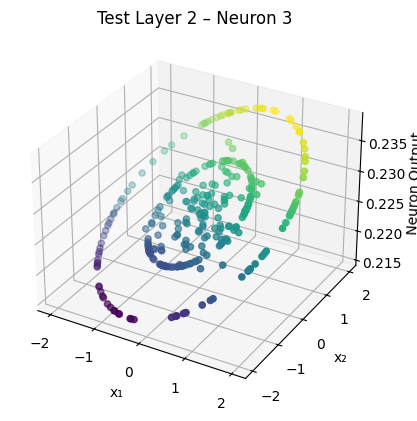

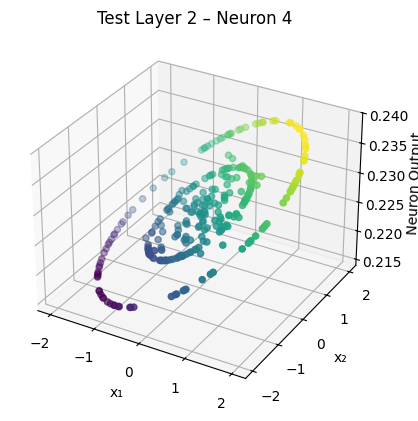

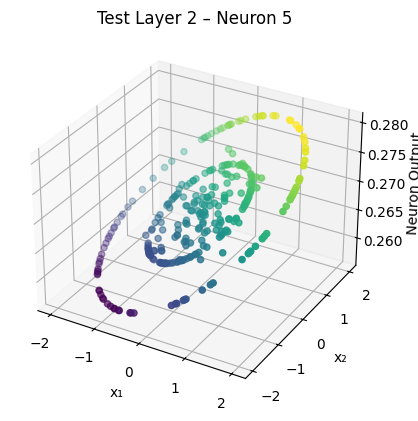

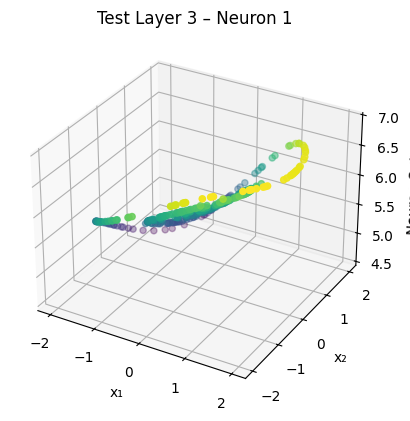

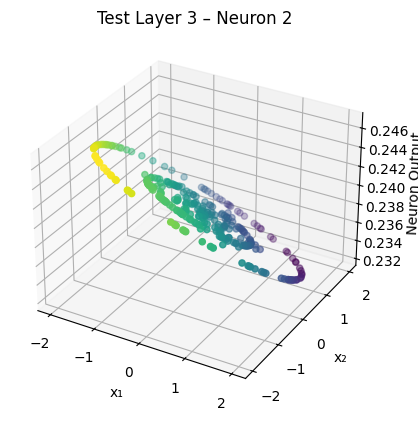

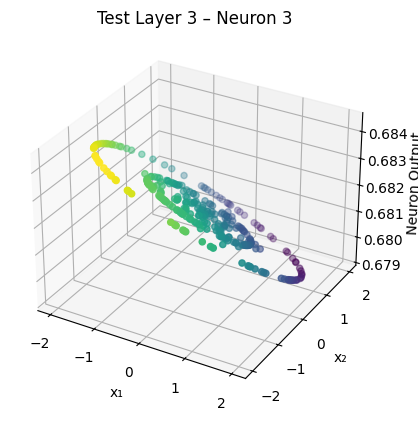

In [69]:
print("Training Data")
plot_node_outputs(model2, X_tr, "Train")

print("Validation Data")
plot_node_outputs(model2, X_val, "Validation")

print("Test Data")
plot_node_outputs(model2, X_te, "Test")


In [70]:
class Perceptron:
    def __init__(self, input_size, lr=0.05):
        self.W = np.random.randn(input_size)
        self.b = 0
        self.lr = lr

    def forward(self, x):
        z = np.dot(x, self.W) + self.b
        return 1 if z >= 0 else 0

    def train(self, X, y, epochs=100):
        for _ in range(epochs):
            for xi, yi in zip(X, y):
                y_hat = self.forward(xi)
                error = yi - y_hat
                self.W += self.lr * error * xi
                self.b += self.lr * error


In [71]:
# Reduce to binary for perceptron comparison
mask = y_tr != 2
X_bin = X_tr[mask]
y_bin = y_tr[mask]

p = Perceptron(2)
p.train(X_bin, y_bin, epochs=100)

preds = np.array([p.forward(x) for x in X_bin])
print("Perceptron Accuracy (Dataset-1 Binary):", np.mean(preds == y_bin))

Perceptron Accuracy (Dataset-1 Binary): 0.5


In [72]:
mask = y_tr != 2
X_bin = X_tr[mask]
y_bin = y_tr[mask]

p = Perceptron(2)
p.train(X_bin, y_bin, epochs=100)

preds = np.array([p.forward(x) for x in X_bin])
print("Perceptron Accuracy (Dataset-2 Binary):", np.mean(preds == y_bin))


Perceptron Accuracy (Dataset-2 Binary): 0.5
